In [1]:
# *** Packages ***
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from math import floor

In [2]:
'''
Q1
'''
batch_size = 32

dataset_train= datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_test= datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = DataLoader(dataset_test, batch_size=len(dataset_test))

classes_name = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
classes_map = {
    0 : 'plane',
    1 : 'car',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

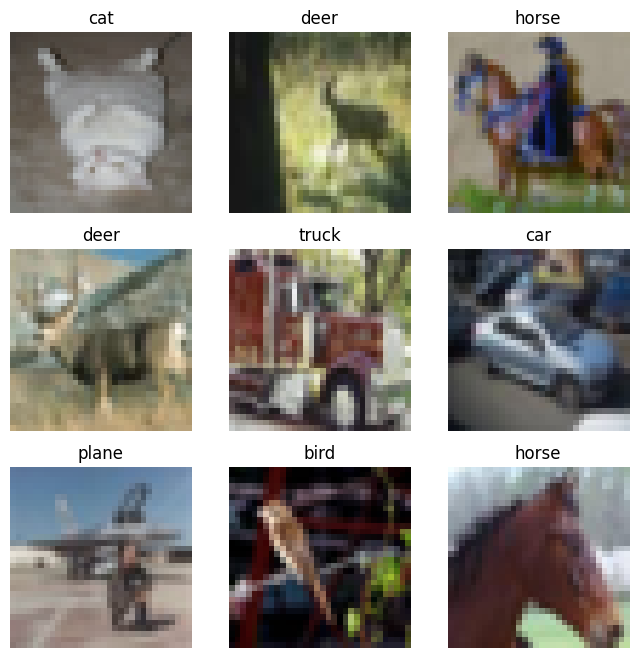

In [7]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_train), size=(1,)).item()
    img, label = dataset_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)

    plt.title(classes_map[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [90]:
len(dataset_train), len(dataset_test)

(50000, 10000)

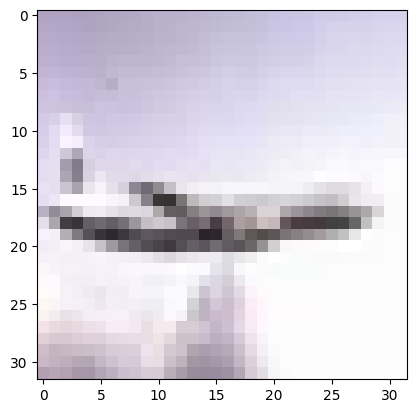

plane horse frog  cat   ship  bird  truck horse ship  frog 


tensor([0, 7, 6, 3, 8, 2, 9, 7, 8, 6, 5, 1, 7, 0, 0, 6, 6, 4, 7, 5, 4, 6, 8, 7,
        5, 1, 3, 1, 0, 0, 0, 5])

In [149]:
'''
Q1
'''
# functions to show an image

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes_name[labels[j]]:5s}' for j in range(10)))

labels

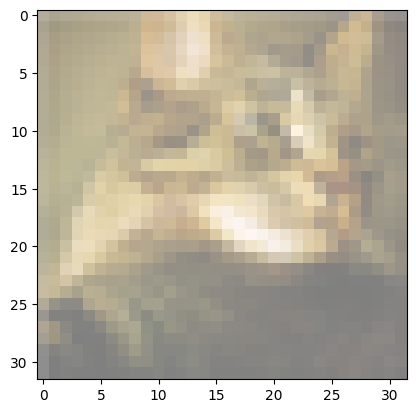

In [145]:
imshow(images[3])

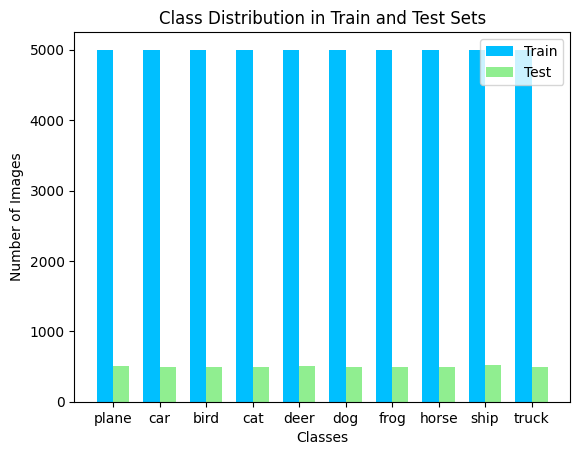

9

In [146]:
'''
Q1
'''
# Funzione per estrarre tutte le etichette dal dataloader
def get_labels_from_loader(loader):
    all_labels = []
    for _, labels in loader:
        all_labels.extend(labels.numpy())  # Estraiamo le etichette come array numpy
    return np.array(all_labels)

# Otteniamo le etichette da train e test
train_label = get_labels_from_loader(trainloader)
test_label = get_labels_from_loader(testloader)

# Calcoliamo la distribuzione delle classi
_, train_counts = np.unique(train_label, return_counts=True)
_, test_counts = np.unique(test_label, return_counts=True)

# Creiamo il grafico comparativo
bar_width = 0.35
index = np.arange(len(classes_name))

plt.bar(index, train_counts, bar_width, label='Train', color='deepskyblue')
plt.bar(index + bar_width, test_counts, bar_width, label='Test', color='lightgreen')

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Train and Test Sets')
plt.xticks(index + bar_width / 2, classes_name)
plt.legend()
plt.show()

train_label[3]

In [94]:
'''
Q3
'''
# Prendi la prima immagine del batch
first_image = images[0]

# Stampa la dimensione dell'immagine
print(f"Shape of the image tensor: {first_image.shape}")  # (C, H, W)

# Puoi separare in Channels, Height, Width
channels, height, width = first_image.shape
print(f"Width: {width}, Height: {height}, Channels: {channels}")

Shape of the image tensor: torch.Size([3, 32, 32])
Width: 32, Height: 32, Channels: 3


In [95]:
'''
Q4
'''
normalize = transforms.Normalize((0,0,0),(1,1,1))

for images, labels in trainloader:
    # Manually normalize the batch of images
    normalized_images = normalize(images)

for images, labels in testloader:
    # Manually normalize the batch of images
    normalized_images = normalize(images)

In [96]:
'''
Q5
'''
dataset_val, dataset_test = torch.utils.data.random_split(dataset_test, [0.5, 0.5])

validloader = DataLoader(dataset_val, batch_size=len(dataset_val))
testloader = DataLoader(dataset_test, batch_size=len(dataset_test))

In [97]:
'''
Q6
'''
def out_dimensions(conv_layer, h_in, w_in):
    '''
    This function computes the output dimension of each convolutional layers in the most general way. 
    '''
    h_out = floor((h_in + 2 * conv_layer.padding[0] - conv_layer.dilation[0] * (conv_layer.kernel_size[0] - 1) - 1) /
                  conv_layer.stride[0] + 1)
    w_out = floor((w_in + 2 * conv_layer.padding[1] - conv_layer.dilation[1] * (conv_layer.kernel_size[1] - 1) - 1) /
                  conv_layer.stride[1] + 1)
    return h_out, w_out


# You can start by modifyng what we have done in class, or define your model from scratch
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=0, stride=1) # Is in_channels = 1 what you want? No 3 like RGB
        h_out, w_out = out_dimensions(self.conv1, 32, 32) # Is 28 what you want? no, 32 like W and H
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, stride=1) 
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)
        
        # You can double this block! 
        self.fc1 = nn.Linear(32 * h_out * w_out, 10) # What does 32 represent? the input channel coming from the previous block
                                                    #but if we use a MaxPool layer 2x2 before, then the input channel is 16
        # You can add one fully connected layer. What do you have to change?
        self.dimensions_final = (32, h_out, w_out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        n_channels, h, w = self.dimensions_final
        x = x.view(-1, n_channels * h * w)
        x = self.fc1(x)
        return x

In [130]:
'''
Q7
'''
model = CNN()
learning_rate = 0.309
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
    if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)

Working on mps


In [135]:
n_epochs = 4
train_loss_list = []
validation_loss_list = []
for epoch in range(n_epochs):
    loss_train = 0
    for data, target in trainloader:
        # Set the model in training mode
        model.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        # Set the gradient to 0
        optimizer.zero_grad()
        # Make a prediction
        output = model(data)
        # Compute the loss function
        loss = loss_fn(output, target)
        loss_train += loss.item()
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()
    loss_train = loss_train / len(trainloader) # Consider this alternative method of tracking training loss. 
    train_loss_list.append(loss_train)
    
    # At the end of every epoch, check the validation loss value
    with torch.no_grad():
        model.eval()
        for data, target in validloader: # Just one batch
            data, target = data.to(DEVICE), target.to(DEVICE)
            # Make a prediction
            output = model(data)
            # Compute the loss function
            validation_loss = loss_fn(output, target).item()
            print(f"Epoch {epoch + 1}: Train loss: {loss_train}, Validation loss {validation_loss}")
            validation_loss_list.append(validation_loss)
    

Epoch 1: Train loss: nan, Validation loss nan
Epoch 2: Train loss: nan, Validation loss nan
Epoch 3: Train loss: nan, Validation loss nan
Epoch 4: Train loss: nan, Validation loss nan


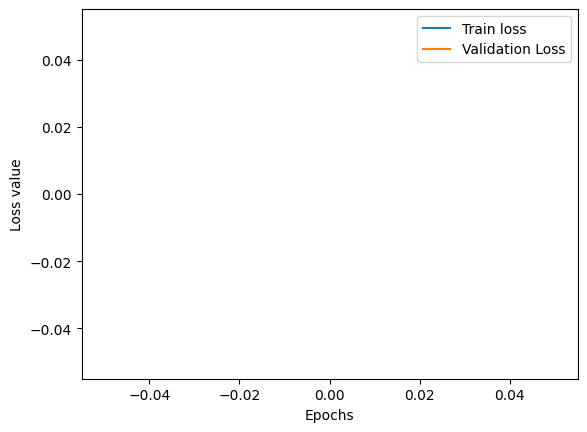

In [134]:
plt.figure()
plt.plot(range(n_epochs), train_loss_list)
plt.plot(range(n_epochs), validation_loss_list)
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

In [133]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in testloader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")

Accuracy on the test set: 0.0 %


## Main

In [61]:
# Write your code here
print("Hello World!")

'''
DON'T MODIFY THE SEED!
'''
# Set the seed for reproducibility
manual_seed = 42
torch.manual_seed(manual_seed)

Hello World!


In [62]:
'''
Q1 - Code
'''
pass

In [63]:
'''
Q2 - Code
'''
    
pass

In [64]:
'''
Q10 -  Code
'''
for seed in range(5,10):
    torch.manual_seed(seed)
    print("Seed equal to ", torch.random.initial_seed())
    # Train the models here


Seed equal to  5
Seed equal to  6
Seed equal to  7
Seed equal to  8
Seed equal to  9
